# Lab 5: Spam Detection

**Deadline**: Thursday, Nov 19, 11:59pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Geoff Donoghue 

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://drive.google.com/file/d/1T-LUV2EcZ8zQvGn305B0c00tO5GPCsmN/view?usp=sharing

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

**ANSWER:**

In [3]:
# Since images are saved on Google Drive, need to mount gdrive and unzip the 
# provided dataset into the /root/spam_dataset folder
from google.colab import drive
drive.mount('/content/gdrive')

!unzip '/content/gdrive/My Drive/Colab Notebooks/APS360/Labs/Lab5/smsspamcollection.zip' -d '/root/spam_dataset'

Mounted at /content/gdrive
Archive:  /content/gdrive/My Drive/Colab Notebooks/APS360/Labs/Lab5/smsspamcollection.zip
  inflating: /root/spam_dataset/SMSSpamCollection  
  inflating: /root/spam_dataset/readme  


### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

**ANSWER:**

In [4]:
# Flags to keep track of whether an example has already been found
find_spam = True
find_ham = True

# Iterate through dataset to search for SMS examples
for line in open('/root/spam_dataset/SMSSpamCollection'):
    
    # Each line consists of two parts that are separated by a tab character: the
    # label ('spam' for spam SMS and 'ham' for non-spam SMS) and the contents of 
    # the corresponding message. To print out the required examples, we first 
    # store the label and message separately
    label, message = line.split('\t')
    
    # Print out the first spam SMS
    if find_spam and label == 'spam':
      print("Example of spam (label value = '{}') SMS:".format(label))
      print(message)
      find_spam = False
    
    # Print out the first non-spam SMS
    if find_ham and label == 'ham':
      print("Example of non-spam (label value = '{}') SMS:".format(label))
      print(message)
      find_ham = False

Example of non-spam (label value = 'ham') SMS:
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

Example of spam (label value = 'spam') SMS:
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


**ANSWER:**

In [5]:
# Counters to count the number of spam and non-spam messages
count_spam = 0
count_ham = 0

# Iterate through dataset to count the number of spam and non-spam messages
for line in open('/root/spam_dataset/SMSSpamCollection'):
  label, message = line.split('\t')
  
  if label == 'spam':
    count_spam += 1
  elif label == 'ham':
    count_ham += 1

# Report the number of spam and non-spam messages
print("Number of spam SMS:", count_spam)
print("Number of non-spam SMS:", count_ham)

Number of spam SMS: 747
Number of non-spam SMS: 4827


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

**ANSWER:**

Advantages:

1. Unlike words, there are a only a certain number of characters in the English (or any) language. This means that the size of a model's vocabulary, while fixed, will be able to include ALL possible character values. As a result, the character-level RNN minimizes the number of inputs that are mapped as an "unknown token", displaying greater resilience to typos, grammatical errors other disparities in the input text.
2. In the final steps of predicting the next token given an input sequence, a softmax function is applied on all the tokens in the model's voacbulary. Since the vocabulary size for a character-level RNN is smaller than a word-level RNN, this computation is much faster and training occurs much faster for a character-level RNN.

Disadvantages:

1. A character-level RNN assumes that the meaning of a word depends on the sequence of letters that make up the word. However, in reality, that is not the case, and the meaning of a word actually depends on the context in which it is used i.e. the sequence of words surrounding the word of interest.
2. Using characters instead of words increases the length of the input sequence, thereby increasing the time needed for computations. For instance, when using a word-level RNN for the sequence "This lab is fun", the sequence has a length of 4. However, if using a character-level RNN, this number increases to 12.

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [6]:
import torchtext

text_field = torchtext.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.data.TabularDataset("/root/spam_dataset/SMSSpamCollection", # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)

# dataset[0].sms
# dataset[0].label

# ANSWER:
train, valid, test = dataset.split([0.6, 0.2, 0.2])

### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [7]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

**ANSWER:**

Having a balanced training set ensures that our model is equally exposed to all classes involved. This removes any biases that may arise out of not seeing a class of samples enough (or seeing a class of samples too many times). For example, as an extreme example, if the model only sees emails that are classified as "spam", it may learn to predict "spam" regardless of the actual contents of the email, which is definitely not something that we would want.

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [8]:
text_field.build_vocab(train)
# text_field.vocab.stoi
# text_field.vocab.itos

**ANSWER:**

`text_field.vocab` represents the model's vocabulary created from the training dataset. `text_field.vocab.stoi` takes each character in the vocabulary (data type: string) and maps it to a number (data type: integer), outputting a dictionary-like structure with the characters and integer mappings as the keys and values, respectively. `text_field.vocab.itos` is the opposite, consisting of a list whose integer indices are mapped to string characters.

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

**ANSWER:**

`<unk>` represents "unknown" characters, or characters that never appear in the training dataset. `<pad>` represents the extra characters appended to the end of a sequence to ensure that all sequences in a single batch have the same length. It is similar to the padding applied around images.

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [9]:
train_iter = torchtext.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

**ANSWER:**

In [10]:
for i, batch in enumerate(train_iter, 0):
    # Execute code below for first ten batches
    if i >= 10:
      break

    batch_l = list(batch.sms[0].view(-1).numpy())
    count_pads = batch_l.count(text_field.vocab.stoi['<pad>'])

    # Report maximum length of input sequence and number of <pad>'s in each batch
    print("Batch: {}, Max Length: {}, <pad> Tokens: {}".format(i, batch.sms[0].shape[1], count_pads))
    
# print(len(batch))
# print(batch.sms[0])
# print(batch.label)

Batch: 0, Max Length: 144, <pad> Tokens: 27
Batch: 1, Max Length: 155, <pad> Tokens: 0
Batch: 2, Max Length: 32, <pad> Tokens: 9
Batch: 3, Max Length: 74, <pad> Tokens: 24
Batch: 4, Max Length: 59, <pad> Tokens: 51
Batch: 5, Max Length: 147, <pad> Tokens: 13
Batch: 6, Max Length: 23, <pad> Tokens: 30
Batch: 7, Max Length: 145, <pad> Tokens: 0
Batch: 8, Max Length: 67, <pad> Tokens: 47
Batch: 9, Max Length: 152, <pad> Tokens: 0


## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [11]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
type(ident)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


**ANSWER:**

In [37]:
class SMSClassifyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SMSClassifyRNN, self).__init__()
        self.one_hot_enc = torch.eye(input_size) # one-hot encording on input
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.rnn = nn.RNN(input_size, hidden_size, num_classes, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 30)
        self.fc2 = nn.Linear(30, num_classes)

    
    def forward(self, x):
        # Determine the one-hot embedding
        x = self.one_hot_enc[x]
        # Set an initial hidden state
        h0 = torch.zeros(self.num_classes, x.size(0), self.hidden_size)
        # c0 = torch.zeros(self.num_classes, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        out = self.fc1(torch.max(out, dim=1)[0])
        out = self.fc2(torch.relu(out))
        return out

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [24]:
def get_accuracy(model, data_iter, loss_calc=False, criterion='N/A'):
    """ Compute the accuracy of the `model` across a dataset `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """

    # ANSWER:
    
    # Set up counts to hold number of correct and total predictions made
    # Set up list to hold loss calculations if needed
    correct, total = 0, 0
    data_loss = []
    
    for batch in data_iter:
        # Determine model predictions given a set of messages
        output = model(batch.sms[0])
        pred = output.max(1, keepdim=True)[1]

        # Update counts for correct and total predictions
        correct += pred.eq(batch.label.view_as(pred)).sum().item()
        total += batch.sms[1].shape[0]
    
    # Output final accuracy and loss
    if loss_calc == True:
        loss = criterion(output, batch.label)
        data_loss.append(float(loss))
        return data_loss, correct / total
    else:
        return correct/total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

**ANSWER:**

In [25]:
# Create BucketIterator objects for the validation dataset
valid_iter = torchtext.data.BucketIterator(valid,
                                          batch_size=32,
                                          sort_key=lambda x: len(x.sms), # minimize padding
                                          sort_within_batch=True,        # sort within each batch
                                          repeat=False)                  # repeat the iterator for many epochs

In [26]:
# Define a train function for the model
import matplotlib.pyplot as plt

def train_network(model, train_iter, valid_iter, batch_size=32, num_epochs=5, learning_rate=1e-5):
    
    # Define the loss and optimizer functions for gradient descent
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Set up lists to hold training and validation accuracies and losses
    train_losses, valid_losses, train_acc, valid_acc = [], [], [], []
    epochs = []

    for epoch in range(num_epochs):
        for batch in train_iter:
            # Gradient descent to update model parameters
            optimizer.zero_grad()
            pred = model(batch.sms[0])
            loss = criterion(pred, batch.label)
            loss.backward()
            optimizer.step()

        # Keep track of training loss    
        train_losses.append(float(loss))     
        
        # Store accuracy/loss information periodically
        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_iter))
        vloss, vacc = get_accuracy(model, valid_iter, loss_calc=True, criterion=criterion)
        valid_acc.append(vacc)
        valid_losses.append(vloss)

    return train_losses, valid_losses, train_acc, valid_acc, epochs


# Define a function for plotting learning curves

def plot_curves(train_losses, valid_losses, train_acc, valid_acc, epochs):
    plt.title("Training Curve")
    plt.plot(train_losses, label="Train")
    plt.plot(valid_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="best")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    # Report final training and validation accuracies
    print("Final Training Accuracy:", train_acc[-1])
    print("Final Validation Accuracy", valid_acc[-1])

In [38]:
# Create RNN classifier to classify spam and no-spam emails
model = SMSClassifyRNN(len(text_field.vocab.itos), 50, 2)

# Train RNN classifier
train_losses, valid_losses, train_acc, valid_acc, epochs = train_network(model, train_iter, valid_iter, num_epochs=30)

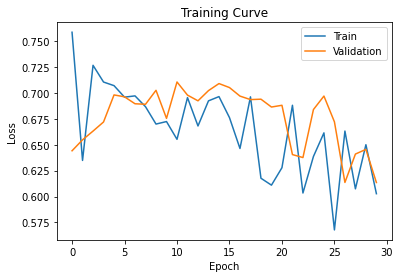

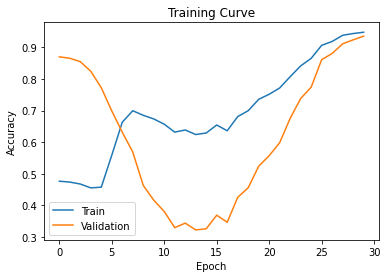

Final Training Accuracy: 0.9478217657777042
Final Validation Accuracy 0.9354260089686098


In [28]:
# Plot learning curves of RNN classifier
plot_curves(train_losses, valid_losses, train_acc, valid_acc, epochs)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

**ANSWER:**

Selected hyperparameters to tune:

1. Choice of neural network

> Three different models were tested: RNN, LSTM and GRU. The validation accuracies were 90.76%, 54.23% and 12.38%, respectively. This result is unexpected because while being good at capturing recent information, RNNs experience difficulties when having to preserve sequential data over a long period of time. In spam classification, this means that if the end of a spam SMS looks "un-suspicious", there is a very good chance that the RNN will classify the message as "not spam". Therefore, we would expect LSTMs and GRUs to have higher accuracies and lower losses. Based on the results achieved, however, I made the decision to choose an RNN for my neural network.  

2. Dimension of the hidden units

> Various numbers lower than, greater than and equal to 50 were tested. Generally, there didn't seem to be a relation between the number of hidden units and validation accuracy/loss. For instance, for 40, 50 and 60 hidden units, the validation accuracies were 93.09%, 90.76% and 93.00%, respectively. The number of hidden units specifies the dimensionality of the state vector. Since having a large state vector increases the number of model parameters and requires a larger dataset to train properly, I decided to pick the smallest number of hidden units that produced relatively good results. As a result, I decided to choose 40 hidden units for my model.

3. Choice of output value for final token

> Three different options were considered: use the output from the RNN directly, use the output of max-pooling over the output array and use the output of max-pooling and average-pooling over the output array. The validation accuracies were 91.65%, 94.26% and 94.75%, respectively. Since the max-pooling output and the concatenation of max- and average-pooling output had similar, highest validation accuracies and lowest validation losses, indicating good model performance and confidence about predictions, I made the decision to use the max-pooling output as the model's final token output.

4. Number of training epochs

This hyperparameter was tuned to prevent the final model from overfitting to the training dataset. As seen in the learning curves from Part 2(b), the training and validation accuracy curves start flattening after around 30 epochs. There is a similar trend for the training and validation loss curves. This is an indication that the model has trained well, and increasing the number of training epochs beyond this value will result in a divergence of the training and validation curves, indicating overfitting. Therefore, I decided to train the neural network for 30 epochs.

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [29]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)

# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)

# ANSWER:
valid_spam_iter = torchtext.data.BucketIterator(valid_spam,
                                                batch_size=len(valid_spam),
                                                sort_key=lambda x: len(x.sms),
                                                sort_within_batch=True,
                                                repeat=False)

valid_nospam_iter = torchtext.data.BucketIterator(valid_nospam,
                                                  batch_size=len(valid_nospam),
                                                  sort_key=lambda x: len(x.sms),
                                                  sort_within_batch=True,
                                                  repeat=False)

# Calculate the false positive and false negative rates
false_positive = 1 - get_accuracy(model, valid_nospam_iter)
false_negative = 1 - get_accuracy(model, valid_spam_iter)

# Report the false positive and false negative rates
print("False positive rate: {}".format(false_positive))
print("False negative rate: {}".format(false_negative))

False positive rate: 0.05658436213991769
False negative rate: 0.0699300699300699


**ANSWER:**



### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

**ANSWER:**

For this spam classification problem, a false positive is defined as classifying a no-spam SMS as "spam". Messages that are wrongly classified as spam could contain important information that is very relevant to the phone's user, such as work emails, meeting invites, etc. Classifying these messages as spam would prevent the user from accessing them, making false positives very inconvenient to the phone's user.

On the other hand, a false negative is classifying a spam SMS as "not spam". False negatives are much more than an inconvenience. Failing to flag down a spam SMS can have serious consequences as there is no indication that the message contains information that is harmful to the phone's user. For instance, if the user received an SMS with a malicious link and the classifier failed to classify this as spam, they may assume that the link is safe to open and proceed.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

**ANSWER:**

In [30]:
# Create BucketIterator objects for the test dataset
test_iter = torchtext.data.BucketIterator(test,
                                          batch_size=32,
                                          sort_key=lambda x: len(x.sms),
                                          sort_within_batch=True,
                                          repeat=False)

# Calculate the final test accuracy of the model
test_acc = get_accuracy(model, test_iter)

# Report the final test accuracy of the model
print("Final Test Accuracy: {}".format(test_acc))

Final Test Accuracy: 0.9515260323159784


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

**ANSWER:**

In [31]:
# Create a Dataset of only test validation examples
test_spam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)

# Create a Dataset of only non-spam test examples
test_nospam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields)

# ANSWER:
test_spam_iter = torchtext.data.BucketIterator(test_spam,
                                               batch_size=len(test_spam),
                                               sort_key=lambda x: len(x.sms),
                                               sort_within_batch=True,
                                               repeat=False)

test_nospam_iter = torchtext.data.BucketIterator(test_nospam,
                                                 batch_size=len(test_nospam),
                                                 sort_key=lambda x: len(x.sms),
                                                 sort_within_batch=True,
                                                 repeat=False)

# Calculate the false positive and false negative rates
false_positive = 1 - get_accuracy(model, test_nospam_iter)
false_negative = 1 - get_accuracy(model, test_spam_iter)

# Report the false positive and false negative rates
print("False positive rate: {}".format(false_positive))
print("False negative rate: {}".format(false_negative))

False positive rate: 0.03962460896767461
False negative rate: 0.07741935483870965


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [32]:
msg = "machine learning is sooo cool!"

**ANSWER:**

In [33]:
# Create a numpy array to hold the character embeddings for the message
msg_char = np.zeros((len(msg)))
for i in range(0, len(msg)):
  msg_char[i] = text_field.vocab.stoi[msg[i]]

# Convert the numpy array into a tensor and adjust the shape to match the input
# requirements for the RNN classifier
msg_char = torch.from_numpy(msg_char).unsqueeze(0).type(torch.LongTensor)

# Compute the model prediction. Use a sigmoid activation function to convert the
# results into a probability distribution
prediction = torch.sigmoid(model(msg_char)).detach()

# Report the model's prediction of the probability that msg is a spam SMS
print("Probability that msg is spam: {}".format(prediction[0][1]))

Probability that msg is spam: 0.4932442009449005


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

**ANSWER:**

Spam detection is a relatively difficult task for AI. This is because spam content do not have consistent formats, sequentially-related informations or distinguishing class features, all of which are helpful, if not necessary, for a successful classification. 

A popular baseline model used for spam classification is a Bernoulli Naive Bayes Classifier, which takes a probabilistic approach to machine learning. This algorithm, dedicated to classes that have binary values such as 0/1 for no-spam/spam, is based on Bayes' Theorem [1] stated below:

> P(A|B) = P(B|A) \* P(A) * (1/P(B))

For the spam classification problem, we can tailor this to be:

> P("spam"|"characters") = P("characters"|"spam") \* P("spam") * (1/P("characters"))

There are two parts to Bayes Theorem that need to be calculated from the training dataset:
1. P("characters"|"spam"): the likelihood probability function
2. P("spam"): the prior probability distribution of the two classes

A simple baseline model can be implemented using a Python library [2] as follows:

1. Import naiveBayes.BernoulliNB from sklearn
2. Instantiate the classifier with uniform prior distribution of the classes i.e. before the model has had a chance to observe any data, it will classify an email as "spam" or "not-spam" with a probability of 50%. 
3. Train the model using the training dataset. The model will learn the likelihood function from this step.
4. Test the model's performance using the validation/test dataset.

<br> References:

[1] "Naive Bayes Classifier," Towards Data Science. [Online]. Available: https://towardsdatascience.com/naive-bayes-classifier-81d512f50a7c. [Accessed: 19-Nov-2020].

[2] "BernoulliNB Documentation". [Online]. Available: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB. [Accessed: 19-Nov-2020]